#### 必要なライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import japanize_matplotlib
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm


#### 共通関数のインポート
著者が学習用、予測用、学習用ログ解析用、図示用の関数を用意してくださっているのでそちらを利用する

In [3]:
!git clone https://github.com/makaishi2/pythonlibs.git

from pythonlibs.torch_lib1 import *

fatal: destination path 'pythonlibs' already exists and is not an empty directory.


#### GPUの確認

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データの準備

In [5]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from io import BytesIO

# Define a custom transform to upscale images
class UpscaleTransform:
    def __init__(self, scale_factor):
        self.scale_factor = scale_factor

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            # If img is a tensor, convert it to PIL image
            img = transforms.ToPILImage()(img)

        # Convert PIL image to tensor
        img_tensor = transforms.ToTensor()(img).unsqueeze(0)
        
        # Calculate the new size
        new_size = [int(d * self.scale_factor) for d in img_tensor.shape[2:]]
        
        # Upsample the image
        img_tensor = F.interpolate(img_tensor, size=new_size, mode='bilinear', align_corners=False)
        
        # Convert tensor back to PIL image
        img = transforms.ToPILImage()(img_tensor.squeeze(0))
        return img


# Define transformations including upscaling

scale_factor=1

transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image
    #transforms.Lambda(lambda x: UpscaleTransform(scale_factor)(x)),  # Upscale the image
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the image
])
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)  # Randomly erase part of the image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the image
])

# Define datasets
train_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/test', transform=transform)
val_dataset = datasets.ImageFolder(root='/usr/src/tiny-imagenet-200/val_reorganized', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

print(f"Train loader has {len(train_loader.dataset)} images.")
print(f"Test loader has {len(test_loader.dataset)} images.")
print(f"Validation loader has {len(val_loader.dataset)} images.")


Train loader has 100000 images.
Test loader has 10000 images.
Validation loader has 10000 images.


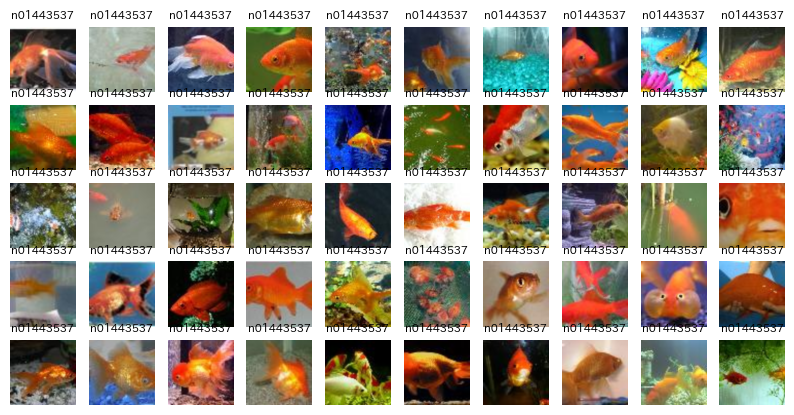

In [47]:
# Get class names (folder names) from the val_dataset
class_names = val_dataset.classes

# Get a batch of data from the val_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Function to convert tensor to numpy array
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Function to show 50 images with their corresponding folder names
def show_images(images, labels, class_names, num_images=50):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(10, 10, i + 1)  # Arrange images in a 10x10 grid
        imshow(images[i])
        folder_label = class_names[labels[i].item()]  # Get folder name using label
        plt.title(folder_label, fontsize=8)  # Display folder name
        plt.axis('off')
    plt.show()

# Show 50 images and their folder names
show_images(images[:50], labels[:50], class_names)

#### Data Augmentation

#### CNNドロップアウト

In [5]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))  # 64x64x3 → 64x64x32
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))  # 64x64x32 → 64x64x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))  # 32x32x32 → 32x32x64
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))  # 32x32x64 → 32x32x64
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1)) # 16x16x64 → 16x16x128
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1)) # 16x16x128 → 16x16x128
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(32768, 128)  # 8x8x128 → 8192
        self.l2 = nn.Linear(128, 200)  # 128 → 200
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3
    
    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

In [6]:
import numpy as np
import torch
import random

# 乱数の固定化
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# モデルインスタンス生成
net = CNN_v3(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# 訓練と検証
num_epochs = 50
history12 = np.zeros((0, 5))
history12 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history12)

# 評価履歴の表示
evaluate_history(history12)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history12)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/50], loss: 5.20994 acc: 0.01199 val_loss: 5.05918, val_acc: 0.02440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/50], loss: 5.00655 acc: 0.02752 val_loss: 4.80559, val_acc: 0.04900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/50], loss: 4.82572 acc: 0.04250 val_loss: 4.59705, val_acc: 0.07670


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/50], loss: 4.68857 acc: 0.05729 val_loss: 4.46449, val_acc: 0.09070


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/50], loss: 4.58389 acc: 0.06763 val_loss: 4.36640, val_acc: 0.10540


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/50], loss: 4.49087 acc: 0.07843 val_loss: 4.27028, val_acc: 0.11350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/50], loss: 4.40349 acc: 0.08908 val_loss: 4.16731, val_acc: 0.13130


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/50], loss: 4.33751 acc: 0.09742 val_loss: 4.06705, val_acc: 0.14350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/50], loss: 4.26827 acc: 0.10510 val_loss: 4.00851, val_acc: 0.15280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/50], loss: 4.20834 acc: 0.11299 val_loss: 3.94525, val_acc: 0.16250


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/50], loss: 4.15206 acc: 0.12086 val_loss: 3.88404, val_acc: 0.16720


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/50], loss: 4.10491 acc: 0.12660 val_loss: 3.82870, val_acc: 0.17730


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/50], loss: 4.06232 acc: 0.13288 val_loss: 3.82790, val_acc: 0.17220


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/50], loss: 4.01881 acc: 0.13898 val_loss: 3.74941, val_acc: 0.18760


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/50], loss: 3.99586 acc: 0.14286 val_loss: 3.69289, val_acc: 0.19710


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/50], loss: 3.95083 acc: 0.14863 val_loss: 3.68955, val_acc: 0.19780


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/50], loss: 3.92188 acc: 0.15132 val_loss: 3.63910, val_acc: 0.20610


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/50], loss: 3.89342 acc: 0.15622 val_loss: 3.59851, val_acc: 0.21150


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/50], loss: 3.85870 acc: 0.16057 val_loss: 3.54774, val_acc: 0.21940


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/50], loss: 3.83365 acc: 0.16346 val_loss: 3.54034, val_acc: 0.22030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/50], loss: 3.80879 acc: 0.16761 val_loss: 3.53811, val_acc: 0.21860


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/50], loss: 3.78220 acc: 0.17160 val_loss: 3.49377, val_acc: 0.22490


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/50], loss: 3.76550 acc: 0.17279 val_loss: 3.48814, val_acc: 0.22470


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/50], loss: 3.73529 acc: 0.17572 val_loss: 3.45516, val_acc: 0.23280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/50], loss: 3.72308 acc: 0.17840 val_loss: 3.42506, val_acc: 0.23640


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/50], loss: 3.69699 acc: 0.18096 val_loss: 3.42706, val_acc: 0.23930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/50], loss: 3.67931 acc: 0.18573 val_loss: 3.40798, val_acc: 0.23820


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Resnet構造

In [6]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/50], loss: 4.37428 acc: 0.09009 val_loss: 3.91506, val_acc: 0.14310


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/50], loss: 3.52001 acc: 0.20407 val_loss: 3.31387, val_acc: 0.24170


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/50], loss: 3.09134 acc: 0.28031 val_loss: 3.01757, val_acc: 0.29990


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/50], loss: 2.78046 acc: 0.34027 val_loss: 2.80206, val_acc: 0.34570


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/50], loss: 2.52736 acc: 0.38832 val_loss: 2.66543, val_acc: 0.36320


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/50], loss: 2.31144 acc: 0.43245 val_loss: 2.63981, val_acc: 0.37970


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/50], loss: 2.11809 acc: 0.47232 val_loss: 2.44508, val_acc: 0.41570


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.93588 acc: 0.51152 val_loss: 2.39543, val_acc: 0.42930


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.75777 acc: 0.54873 val_loss: 2.30950, val_acc: 0.45280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.58825 acc: 0.58567 val_loss: 2.37197, val_acc: 0.44730


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.42399 acc: 0.62324 val_loss: 2.40570, val_acc: 0.45190


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.26513 acc: 0.65917 val_loss: 2.41524, val_acc: 0.45860


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.11142 acc: 0.69697 val_loss: 2.44645, val_acc: 0.46330


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.97299 acc: 0.72843 val_loss: 2.61006, val_acc: 0.45460


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.83180 acc: 0.76472 val_loss: 2.65315, val_acc: 0.45450


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.71749 acc: 0.79358 val_loss: 2.82012, val_acc: 0.45360


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.62349 acc: 0.81809 val_loss: 2.89803, val_acc: 0.45690


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.54122 acc: 0.84210 val_loss: 2.95434, val_acc: 0.45860


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.47800 acc: 0.85797 val_loss: 3.06817, val_acc: 0.45670


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.41921 acc: 0.87532 val_loss: 3.21211, val_acc: 0.45030


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.38035 acc: 0.88516 val_loss: 3.33888, val_acc: 0.44880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.35281 acc: 0.89389 val_loss: 3.38702, val_acc: 0.44850


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.31622 acc: 0.90359 val_loss: 3.48600, val_acc: 0.44770


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.30010 acc: 0.90846 val_loss: 3.50550, val_acc: 0.44800


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.27472 acc: 0.91449 val_loss: 3.55304, val_acc: 0.44800


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.25458 acc: 0.92114 val_loss: 3.55846, val_acc: 0.45710


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.24483 acc: 0.92409 val_loss: 3.75461, val_acc: 0.44010


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.23194 acc: 0.92798 val_loss: 3.67163, val_acc: 0.45250


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.21912 acc: 0.93169 val_loss: 3.80301, val_acc: 0.44310


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.21088 acc: 0.93383 val_loss: 3.82903, val_acc: 0.44890


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.20510 acc: 0.93590 val_loss: 3.84327, val_acc: 0.45160


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.18348 acc: 0.94237 val_loss: 3.81093, val_acc: 0.45610


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.17951 acc: 0.94336 val_loss: 3.90468, val_acc: 0.45300


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.18296 acc: 0.94242 val_loss: 4.02314, val_acc: 0.44260


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.16841 acc: 0.94675 val_loss: 3.95397, val_acc: 0.45460


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.15266 acc: 0.95180 val_loss: 3.98730, val_acc: 0.44840


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.16623 acc: 0.94723 val_loss: 4.00270, val_acc: 0.44920


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.15432 acc: 0.95197 val_loss: 4.03657, val_acc: 0.45210


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.14191 acc: 0.95474 val_loss: 4.09113, val_acc: 0.44300


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.13983 acc: 0.95604 val_loss: 4.16286, val_acc: 0.44980


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.13788 acc: 0.95723 val_loss: 4.08326, val_acc: 0.44750


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.13820 acc: 0.95643 val_loss: 4.15886, val_acc: 0.44600


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.13094 acc: 0.95816 val_loss: 4.19498, val_acc: 0.43860


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.12722 acc: 0.95959 val_loss: 4.19450, val_acc: 0.45290


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.12385 acc: 0.96033 val_loss: 4.19903, val_acc: 0.45110


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.12046 acc: 0.96195 val_loss: 4.18483, val_acc: 0.45350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.11699 acc: 0.96226 val_loss: 4.31669, val_acc: 0.45070


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.11486 acc: 0.96328 val_loss: 4.26088, val_acc: 0.45870


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.11067 acc: 0.96500 val_loss: 4.28772, val_acc: 0.46070


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.11055 acc: 0.96508 val_loss: 4.29717, val_acc: 0.45490
初期状態: 損失: 3.91506 精度: 0.14310
最終状態: 損失: 4.29717 精度: 0.45490


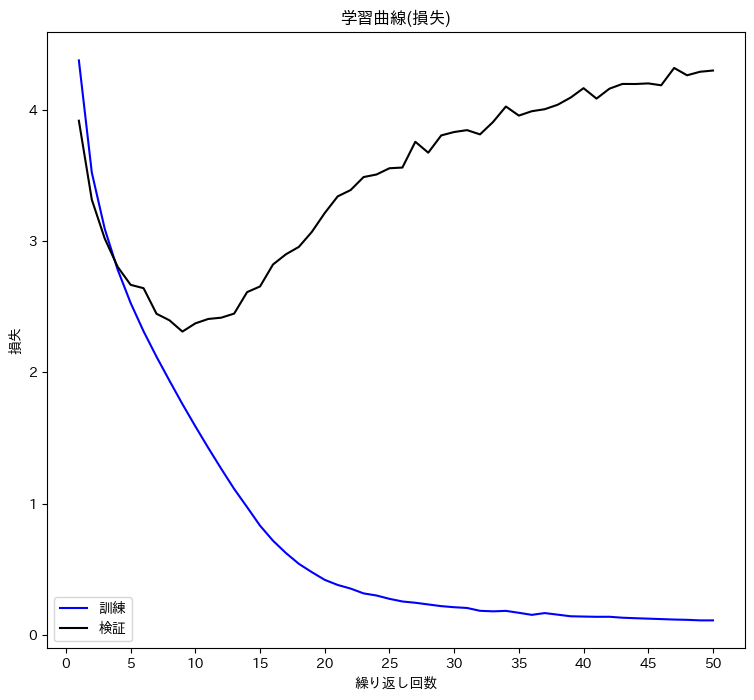

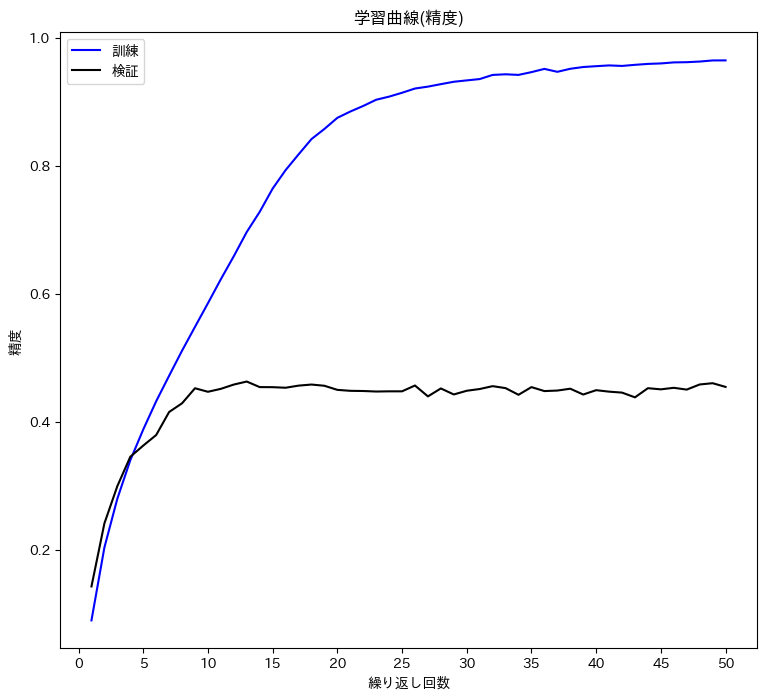

In [9]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 50
history13 = np.zeros((0, 5))
history13 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history13)

# 評価履歴の表示
evaluate_history(history13)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history13)


過学習を防ぐため、dropoutを増加する

In [10]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)  # Apply dropout
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=200, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(dropout_rate) 
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_rate=0.5):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_rate))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

   
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/50], loss: 4.56502 acc: 0.06552 val_loss: 4.02761, val_acc: 0.12200


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/50], loss: 3.74400 acc: 0.16765 val_loss: 3.49424, val_acc: 0.20950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/50], loss: 3.34391 acc: 0.23482 val_loss: 3.38785, val_acc: 0.22960


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/50], loss: 3.06753 acc: 0.28589 val_loss: 3.12231, val_acc: 0.28600


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/50], loss: 2.84027 acc: 0.32885 val_loss: 3.07226, val_acc: 0.30070


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/50], loss: 2.65777 acc: 0.36385 val_loss: 3.01596, val_acc: 0.32160


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/50], loss: 2.48825 acc: 0.39515 val_loss: 2.82289, val_acc: 0.35460


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/50], loss: 2.35187 acc: 0.42454 val_loss: 2.66353, val_acc: 0.38640


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/50], loss: 2.22115 acc: 0.45187 val_loss: 2.60674, val_acc: 0.40450


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/50], loss: 2.09843 acc: 0.47576 val_loss: 2.53253, val_acc: 0.41360


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.99099 acc: 0.49684 val_loss: 2.57368, val_acc: 0.41620


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.88416 acc: 0.51885 val_loss: 2.46523, val_acc: 0.43680


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.79075 acc: 0.53974 val_loss: 2.45330, val_acc: 0.44510


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.69775 acc: 0.55953 val_loss: 2.52097, val_acc: 0.44050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.60191 acc: 0.57755 val_loss: 2.50657, val_acc: 0.44500


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.51689 acc: 0.59858 val_loss: 2.49526, val_acc: 0.45260


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.43589 acc: 0.61705 val_loss: 2.60169, val_acc: 0.44950


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.35849 acc: 0.63418 val_loss: 2.59829, val_acc: 0.45670


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.28702 acc: 0.65027 val_loss: 2.67547, val_acc: 0.45160


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.21749 acc: 0.66715 val_loss: 2.75538, val_acc: 0.44850


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.16033 acc: 0.67818 val_loss: 2.78138, val_acc: 0.45140


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.09694 acc: 0.69425 val_loss: 2.81096, val_acc: 0.45500


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.02990 acc: 0.70944 val_loss: 2.80021, val_acc: 0.45800


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.98956 acc: 0.71885 val_loss: 3.01601, val_acc: 0.44320


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.93162 acc: 0.73311 val_loss: 2.96766, val_acc: 0.44720


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.88466 acc: 0.74399 val_loss: 3.03052, val_acc: 0.45100


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.84014 acc: 0.75537 val_loss: 3.03189, val_acc: 0.45840


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.80260 acc: 0.76459 val_loss: 3.06444, val_acc: 0.45580


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.76564 acc: 0.77419 val_loss: 3.13877, val_acc: 0.45140


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.73272 acc: 0.78290 val_loss: 3.07551, val_acc: 0.46900


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.70034 acc: 0.79131 val_loss: 3.29008, val_acc: 0.45910


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.66952 acc: 0.79835 val_loss: 3.22750, val_acc: 0.46180


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.64847 acc: 0.80296 val_loss: 3.38085, val_acc: 0.45120


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.61625 acc: 0.81378 val_loss: 3.50054, val_acc: 0.44710


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.58973 acc: 0.82126 val_loss: 3.42308, val_acc: 0.46100


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.57345 acc: 0.82441 val_loss: 3.35293, val_acc: 0.46090


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.54977 acc: 0.83197 val_loss: 3.53799, val_acc: 0.45820


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.53208 acc: 0.83666 val_loss: 3.67578, val_acc: 0.44220


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.51189 acc: 0.84323 val_loss: 3.69022, val_acc: 0.45160


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.49563 acc: 0.84681 val_loss: 3.59607, val_acc: 0.46220


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.48320 acc: 0.85065 val_loss: 3.64800, val_acc: 0.45700


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.46926 acc: 0.85549 val_loss: 3.72882, val_acc: 0.45650


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.45330 acc: 0.85897 val_loss: 3.70913, val_acc: 0.45740


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43953 acc: 0.86229 val_loss: 3.83786, val_acc: 0.44830


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42341 acc: 0.86804 val_loss: 3.76822, val_acc: 0.46040


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.41523 acc: 0.86963 val_loss: 3.83687, val_acc: 0.45410


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.39845 acc: 0.87447 val_loss: 3.86811, val_acc: 0.45280


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.39545 acc: 0.87618 val_loss: 3.94854, val_acc: 0.45180


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.38395 acc: 0.87960 val_loss: 4.06636, val_acc: 0.45200


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.37723 acc: 0.88070 val_loss: 3.87013, val_acc: 0.46430
初期状態: 損失: 4.02761 精度: 0.12200
最終状態: 損失: 3.87013 精度: 0.46430


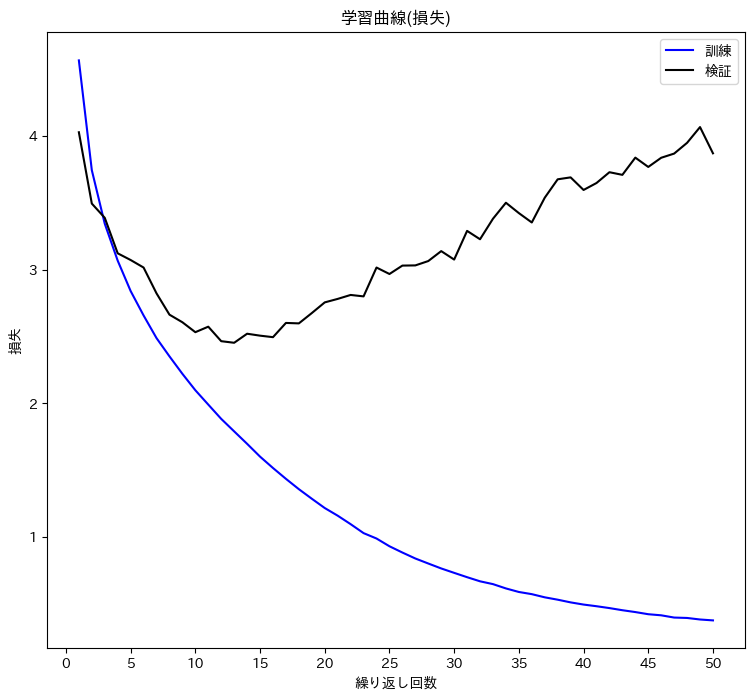

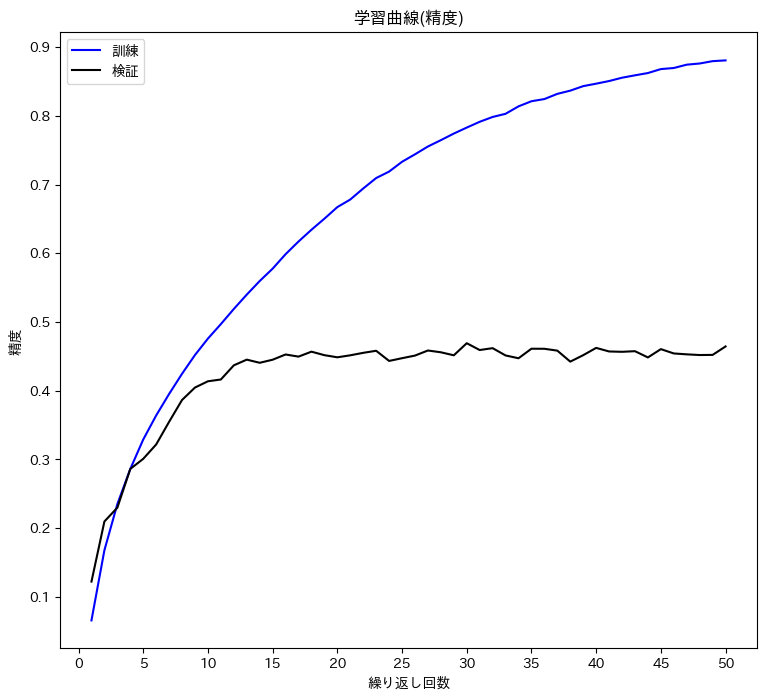

In [11]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
net = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 訓練と検証
num_epochs = 50
history14 = np.zeros((0, 5))
history14 = fit(net, optimizer, criterion, num_epochs, train_loader, val_loader, device, history14)

# 評価履歴の表示
evaluate_history(history14)

# チェックポイントの保存
net.save_checkpoint(num_epochs, net, optimizer, history14)
